# Build phase for developing machine learning models

This notebook builds few models on the `credit_risk_training.csv` dataset and then deploys the model into pre production and production spaces. The goal of this notebook is to predict if a customer's credit is risky or not. And provide a clear explanation for the result. This is accomplished in 5 high-level steps:
   
1. Packages installation:
    * There are some pre-requisite setup steps before building ml models. We first start by installing necessary packages. 
    
    
2. Exploratory Data Analysis (EDA) on the Credit risk dataset: 
    * Explore the behavior of credit risks across features using a combination of a pie chart, a box plot, and a heat map. 
    * Document the relationships/insights for use in model building 
    
        
3. Feature engineering: 
    * Prepare data for model building and testing, by splitting data into features and label data. 
    * Perform feature engineering on some columns 
    
    
4. Model training/building, and ultimately outputs assets to be used in an end to end scoring pipeline.
    * Iteratively train/test models that can improve the prediction accuracy of credit risk.
    * Logistic Regression, Random Forest, and XGBoost models are used in experimentation.
    

5. Evaluate model: 
    * For each model mentioned above, predict and evaluate the output on a testing set. 
    * Save trained model as a Watson Machine Learning model
    



# Install Packages
## Pre-requisite setup steps
Install necessary packages if haven't already with required libraries

In [126]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [127]:
from IPython.display import clear_output
!pip install numpy --no-cache --user | tail -n 1
!pip install lime --no-cache --user | tail -n 1
!pip install upgrade SciPy --no-cache --user | tail -n 1
!pip install pixiedust --user | tail -n 1
!pip install sklearn-pandas --user | tail -n 1
!pip install sklearn2pmml --user | tail -n 1
!pip install scikit-learn==0.24 --user | tail -n 1
!pip install brunel --user | tail -n 1
clear_output(wait=False)

'''
Successfully installed ibm-ai-openscale-2.2.1
Requirement already satisfied: numpy in /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages (1.19.2)
Successfully installed lime-0.2.0.1
ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
  WARNING: The script jupyter-pixiedust is installed in '/home/wsuser/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Successfully installed colour-0.1.5 geojson-2.5.0 pixiedust-1.1.19
Successfully installed scipy-1.7.1 sklearn-pandas-2.2.0
Successfully installed sklearn2pmml-0.74.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoai-libs 1.12.9 requires scikit-learn<0.24,>=0.20.3, but you have scikit-learn 0.24.0 which is incompatible.
Successfully installed scikit-learn-0.24.0'''

"\nSuccessfully installed ibm-ai-openscale-2.2.1\nRequirement already satisfied: numpy in /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages (1.19.2)\nSuccessfully installed lime-0.2.0.1\nERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)\nERROR: No matching distribution found for upgrade\n  WARNING: The script jupyter-pixiedust is installed in '/home/wsuser/.local/bin' which is not on PATH.\n  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.\nSuccessfully installed colour-0.1.5 geojson-2.5.0 pixiedust-1.1.19\nSuccessfully installed scipy-1.7.1 sklearn-pandas-2.2.0\nSuccessfully installed sklearn2pmml-0.74.3\nERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.\nautoai-libs 1.12.9 requires scikit-learn<0.24,>=0.20.3, but you have scikit-learn 0.24.0 wh

## Import necessary packages

In [128]:
import sklearn

import pandas as pd
pd.options.display.max_columns = 999

import brunel

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

import numpy as np

import urllib3, requests, json, os

# 2. Data Analysis <a name="dataanalysis"></a>

## Load the redacted training data from a remote datasource
Click on `Find Data`, then select `Remote` tab and on the data needed click on `Insert Pandas DataFrame in Python`

In [129]:
df1 = pd.read_csv('./assets/data_asset/credit_risk_training.csv')
df1.head()

,customerid,firstname,lastname,address,priphone,secphone,email,custsince,checkingstatus,loanduration,credithistory,loanpurpose,loanamount,existingsavings,employmentduration,installmentpercent,sex,othersonloan,currentresidenceduration,ownsproperty,age,installmentplans,housing,existingcreditscount,job,dependents,telephone,foreignworker,risk
0,00-0685015,Matt,Walli,73184 Marcy Road,411-496-2035,601-660-9721,mattwalli@hotmail.com,2/13/1999,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,male,none,3,savings_insurance,45,none,own,1,skilled,1,none,yes,No Risk
1,00-0825685,Shirley,Han,3683 4th Terrace,960-670-6886,687-782-3977,shirleyhan@google.com,9/25/1981,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,2,savings_insurance,23,stores,own,2,skilled,1,none,yes,No Risk
2,00-1578213,Tim,Bohn,47 Sycamore Street,889-606-3375,914-207-6032,timbohn@yahoo.com,11/5/1982,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,2,savings_insurance,49,none,own,1,skilled,1,none,yes,No Risk
3,00-6538323,Rakshith,DL,77097 Ludington Lane,173-678-8721,913-523-3150,rakshithdl@yahoo.com,3/25/1983,no_checking,32,outstanding_credit,vacation,9604,500_to_1000,greater_7,6,male,co-applicant,5,unknown,26,none,free,2,skilled,2,yes,yes,Risk
4,00-6823285,Jade,Yushu,5516 Park Meadow Park,246-479-8221,442-159-8733,jadeyushu@google.com,2/8/1989,less_0,16,credits_paid_to_date,vacation,3109,less_100,4_to_7,3,female,none,1,car_other,26,none,own,2,skilled,1,none,yes,No Risk


In [130]:
df1.shape

(5001, 29)

## Feature columns

In [131]:
feature_columns = list(df1.columns)
feature_columns.remove('customerid')
feature_columns.remove('firstname')
feature_columns.remove('lastname')
feature_columns.remove('address')
feature_columns.remove('priphone')
feature_columns.remove('secphone')
feature_columns.remove('email')
feature_columns.remove('custsince')

df1 = df1[feature_columns]

## Convert int columns to float

In [132]:
float_columns = ['loanduration', 'loanamount', 'installmentpercent', 'currentresidenceduration', 'age', 'existingcreditscount', 'dependents']
df1[float_columns] = df1[float_columns].astype('float64')
df1.dtypes

checkingstatus               object
loanduration                float64
credithistory                object
loanpurpose                  object
loanamount                  float64
existingsavings              object
employmentduration           object
installmentpercent          float64
sex                          object
othersonloan                 object
currentresidenceduration    float64
ownsproperty                 object
age                         float64
installmentplans             object
housing                      object
existingcreditscount        float64
job                          object
dependents                  float64
telephone                    object
foreignworker                object
risk                         object
dtype: object

## Outcome Variable : Risk
Evaluating the label distribution. An even distibution exists in our dataset between Risk and No Risk labels

In [133]:
import brunel
#%brunel data('df1') x('risk') y(#count) color(risk) bar tooltip(#all)

## Risk by loanpurpose
Riskiest loans are made for repairs while the safest is new cars

In [134]:
#%brunel data('df1') polar stack bar y(#count) color(loanpurpose) percent(#count) tooltip(#all) | stack bar x(loanpurpose) y(#count) color(risk) bin(loanpurpose) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

## Loan amount vs Credit risk
The Risk group has a larger average loan amount

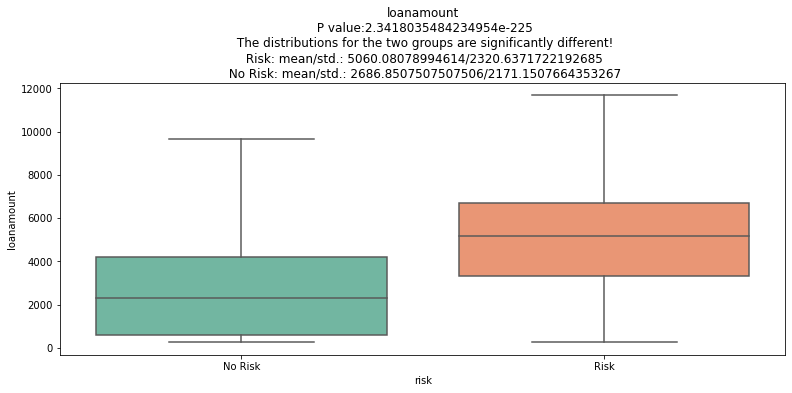

In [135]:
from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

sub_yes = df1[df1["risk"] == 'Risk']
sub_no = df1[df1["risk"] == 'No Risk']
    
p_value = ttest_ind(sub_yes['loanamount'], sub_no["loanamount"], equal_var = False)[1]

fig, axs = plt.subplots(nrows= 1, figsize=(13, 5))
sns.boxplot(x = "risk", y = "loanamount", data = df1, showfliers=False, palette="Set2")
if p_value < .05:
    plt.title("loanamount" + "\n P value:" + str(p_value) + "\n The distributions for the two groups are significantly different!" + "\n Risk: mean/std.: " + str(sub_yes["loanamount"].describe()[1]) + "/" + str(sub_yes["loanamount"].describe()[2]) + "\n No Risk: mean/std.: " + str(sub_no["loanamount"].describe()[1]) + "/" + str(sub_no["loanamount"].describe()[2]))
else:
    plt.title("loanamount" + "\n P value:" + str(p_value) + "\n Risk: mean/std.: " + str(sub_yes["loanamount"].describe()[1]) + "/" + str(sub_yes["loanamount"].describe()[2]) + "\n No Risk: mean/std.: " + str(sub_safe["loanamount"].describe()[1]) + "/" + str(sub_no["loanamount"].describe()[2]))           

## Correlation Matrix - Higher values indicate higher correlation
Loan amount is correlated with Installment percent but not above our threshold for removal


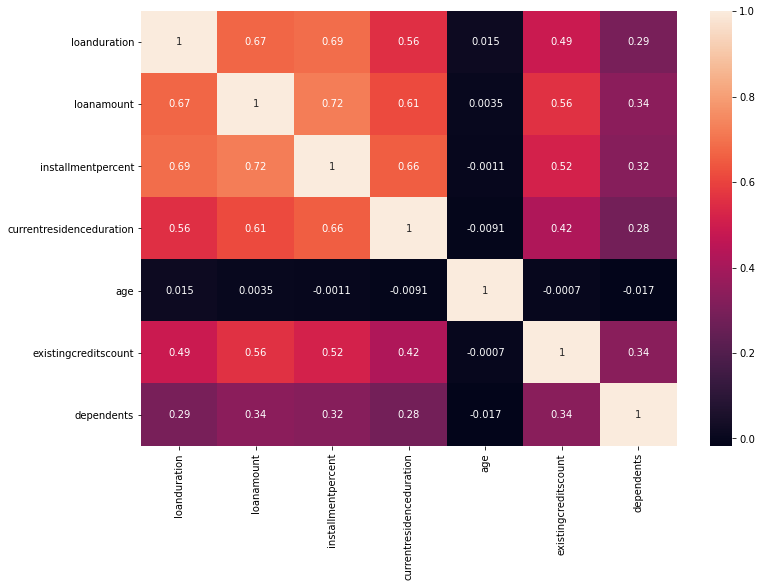

In [136]:
plt.figure(figsize=(12, 8))

corr_df = df1.iloc[:,1:].corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);

# Data Preparation
Prepare data for model building and testing, by splitting data into input features and label data

In [137]:
y = df1['risk']
X = df1.drop(['risk'], axis=1)

In [138]:
import sklearn

import pandas as pd
pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

import numpy as np

import urllib3, requests, json, os

Split data into training and testing, and define the model and deployment name

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=42, stratify=y)

## Prepare the Data frame mapper pipeline - Assign encoders to categorical columns

In [140]:
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper(
    [('checkingstatus', LabelEncoder()),
     ('loanduration', None),
     ('credithistory',LabelEncoder()),
     ('loanpurpose', LabelEncoder()),
     ('loanamount',None),
     ('existingsavings',LabelEncoder()),
     ('employmentduration',LabelEncoder()),
     ('age',None),
     ('sex', LabelEncoder()),
     ('installmentpercent',None),
     ('othersonloan',LabelEncoder()),
     ('ownsproperty',LabelEncoder()),
     ('currentresidenceduration',None),
     ('installmentplans',LabelEncoder()),
     ('housing',LabelEncoder()),
     ('existingcreditscount',None),
     ('job',LabelEncoder()),
     ('dependents',None),
     ('telephone',LabelEncoder()),
     ('foreignworker',LabelEncoder())]
)

## Generate Token

In [141]:
import json
import requests
import base64
from requests.auth import HTTPBasicAuth
import time
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

def generate_access_token():
    headers={}
    headers["Accept"] = "application/json"
    #auth = HTTPBasicAuth('xxx', 'xxxx')
    auth = HTTPBasicAuth('datascientist', 'password')
     
    ICP_TOKEN_URL= 'https://ibm-nginx-svc' + "/v1/preauth/validateAuth"
    
    response = requests.get(ICP_TOKEN_URL, headers=headers, auth=auth, verify=False)
    json_data = response.json()
    icp_access_token = json_data['accessToken']
    return icp_access_token

token = generate_access_token()



## Connect to WML

In [142]:
from ibm_watson_machine_learning import APIClient
import os

token = generate_access_token()

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.5"
}

wml_client = APIClient(wml_credentials)

## Set Client to save in Project

In [143]:
project_uid = os.environ['PROJECT_ID']
wml_client.set.default_project(project_uid)

'SUCCESS'

# Build, Train and Save

## 1.0 Logistic Regression

## 1.1 Build the pipeline and fit the model to training data

In [144]:
mapper = DataFrameMapper(
    [('checkingstatus', LabelEncoder()),
     ('loanduration', None),
     ('credithistory',LabelEncoder()),
     ('loanpurpose', LabelEncoder()),
     ('loanamount',None),
     ('existingsavings',LabelEncoder()),
     ('employmentduration',LabelEncoder()),
     ('installmentpercent',None),
     ('othersonloan',LabelEncoder()),
     ('ownsproperty',LabelEncoder()),
     ('age',None),
     ('sex', LabelEncoder()),
     ('currentresidenceduration',None),
     ('installmentplans',LabelEncoder()),
     ('housing',LabelEncoder()),
     ('existingcreditscount',None),
     ('job',LabelEncoder()),
     ('dependents',None),
     ('telephone',LabelEncoder()),
     ('foreignworker',LabelEncoder())]
)

In [145]:
from sklearn.linear_model import LogisticRegression
# Retrain the model using fewer features
model_select = LogisticRegression()
steps = [('mapper', mapper),('Classifier', model_select)]
pipeline = sklearn.pipeline.Pipeline(steps)
model_lr = pipeline.fit( X_train, y_train )
model_lr

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[('checkingstatus', LabelEncoder()),
                                           ('loanduration', None),
                                           ('credithistory', LabelEncoder()),
                                           ('loanpurpose', LabelEncoder()),
                                           ('loanamount', None),
                                           ('existingsavings', LabelEncoder()),
                                           ('employmentduration',
                                            LabelEncoder()),
                                           ('installmentpercent', None),
                                           ('othersonloan', LabelEncoder()),
                                           ('ownsproperty', LabelEncoder()),
                                           ('age', None),
                                           ('sex', LabelEncoder()),
 

# 1.2 Evaluate Model

## Predict and Evaluate the output of the Logistic Regression model on test data

In [146]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

              precision    recall  f1-score   support

     No Risk       0.78      0.88      0.83      1133
        Risk       0.68      0.51      0.59       568

    accuracy                           0.76      1701
   macro avg       0.73      0.70      0.71      1701
weighted avg       0.75      0.76      0.75      1701



## Save model to WML

In [147]:
MODEL_NAME = 'LR - Credit Risk Pipeline_TAI_demo'

## Delete previous models saved with the same name

In [148]:
for m in wml_client.repository.get_model_details()['resources']:
    if m['metadata']['name'] == MODEL_NAME:
        wml_client.repository.delete(m['metadata']['id'])

In [149]:
model_props_lr = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_uid_by_name('default_py3.8'),
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23"
}

published_model_details = wml_client.repository.store_model(model=model_lr, meta_props=model_props_lr, training_data=X_train,training_target=y_train, feature_names = list(X_train.columns))

## 2.0 Random Forest

## 2.1 Build the pipeline and fit the model to training data

In [150]:
mapper = DataFrameMapper(
    [('checkingstatus', LabelEncoder()),
     ('loanduration', None),
     ('credithistory',LabelEncoder()),
     ('loanpurpose', LabelEncoder()),
     ('loanamount',None),
     ('age',None),
     ('sex', LabelEncoder()),
     ('existingsavings',LabelEncoder()),
     ('employmentduration',LabelEncoder()),
     ('installmentpercent',None),
     ('othersonloan',LabelEncoder()),
     ('ownsproperty',LabelEncoder()),
     ('currentresidenceduration',None),
     ('installmentplans',LabelEncoder()),
     ('housing',LabelEncoder()),
     ('existingcreditscount',None),
     ('job',LabelEncoder()),
     ('dependents',None),
     ('telephone',LabelEncoder()),
     ('foreignworker',LabelEncoder())]
)

In [151]:
from sklearn.ensemble import RandomForestClassifier
# Retrain the model using fewer features
model_select = RandomForestClassifier()
steps = [('mapper', mapper),('Classifier', model_select)]
pipeline = sklearn.pipeline.Pipeline(steps)
model_rf = pipeline.fit( X_train, y_train )
model_rf

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[('checkingstatus', LabelEncoder()),
                                           ('loanduration', None),
                                           ('credithistory', LabelEncoder()),
                                           ('loanpurpose', LabelEncoder()),
                                           ('loanamount', None), ('age', None),
                                           ('sex', LabelEncoder()),
                                           ('existingsavings', LabelEncoder()),
                                           ('employmentduration',
                                            LabelEncoder()),
                                           ('installmentpercent', None),
                                           ('othersonloan', LabelEncoder()),
                                           ('ownsproperty', LabelEncoder()),
                                           (

## 2.2 Predict and Evaluate the output of the Random Forest model on test data

In [152]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

              precision    recall  f1-score   support

     No Risk       0.79      0.90      0.84      1133
        Risk       0.73      0.52      0.61       568

    accuracy                           0.78      1701
   macro avg       0.76      0.71      0.73      1701
weighted avg       0.77      0.78      0.76      1701



## 2.3 Save model to WML

In [153]:
MODEL_NAME = 'RF - Credit Risk Pipeline_TAI_demo'

## Delete previous models saved with the same name

In [154]:
for m in wml_client.repository.get_model_details()['resources']:
    if m['metadata']['name'] == MODEL_NAME:
        wml_client.repository.delete(m['metadata']['id'])

In [155]:
model_props_rf = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_uid_by_name('default_py3.8'),
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23"
}

published_model_details = wml_client.repository.store_model(model=model_rf, meta_props=model_props_rf, training_data=X_train,training_target=y_train, feature_names = list(X_train.columns))

## 3.0 XGBoost

## 3.1 Build the pipeline and fit the model to training data

In [170]:
mapper = DataFrameMapper(
    [('checkingstatus', LabelEncoder()),
     ('loanduration', None),
     ('credithistory',LabelEncoder()),
     ('loanpurpose', LabelEncoder()),
     ('loanamount',None),
     ('existingsavings',LabelEncoder()),
     ('employmentduration',LabelEncoder()),
     ('installmentpercent',None),
     ('othersonloan',LabelEncoder()),
     ('age',None),
     ('sex', LabelEncoder()),
     ('ownsproperty',LabelEncoder()),
     ('currentresidenceduration',None),
     ('installmentplans',LabelEncoder()),
     ('housing',LabelEncoder()),
     ('existingcreditscount',None),
     ('job',LabelEncoder()),
     ('dependents',None),
     ('telephone',LabelEncoder()),
     ('foreignworker',LabelEncoder())]
)

In [171]:
import time
start_time = time.time()

In [172]:
from xgboost import XGBClassifier
# Retrain the model using fewer features
model_select = XGBClassifier(eval_metric='mlogloss')
steps = [('mapper', mapper),('Classifier', model_select)]
pipeline = sklearn.pipeline.Pipeline(steps)
model_xgb = pipeline.fit( X_train, y_train )
model_xgb

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[('checkingstatus', LabelEncoder()),
                                           ('loanduration', None),
                                           ('credithistory', LabelEncoder()),
                                           ('loanpurpose', LabelEncoder()),
                                           ('loanamount', None),
                                           ('existingsavings', LabelEncoder()),
                                           ('employmentduration',
                                            LabelEncoder()),
                                           ('installmentpercent', None),
                                           ('othersonloan', LabelEncoder()),
                                           ('age', None)...
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
          

In [173]:
print("this took:" + str(time.time() - start_time))

this took:7.0930750370025635


## 3.2 Predict and Evaluate the output of the XGBoost model on test data

In [174]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

              precision    recall  f1-score   support

     No Risk       0.80      0.86      0.83      1133
        Risk       0.68      0.57      0.62       568

    accuracy                           0.77      1701
   macro avg       0.74      0.72      0.72      1701
weighted avg       0.76      0.77      0.76      1701



## 3.3 Save model to WML

In [175]:
MODEL_NAME = 'XGB - Credit Risk Pipeline_TAI_demo'

## 3.4 Delete previous models saved with the same name

In [176]:
for m in wml_client.repository.get_model_details()['resources']:
    if m['metadata']['name'] == MODEL_NAME:
        wml_client.repository.delete(m['metadata']['id'])

In [177]:
model_props_xgb = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_uid_by_name('default_py3.8'),
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23"
}

published_model_details = wml_client.repository.store_model(model=model_xgb, meta_props=model_props_xgb, training_data=X_train,training_target=y_train, feature_names = list(X_train.columns))

ApiRequestFailure: Failure during list assets. (GET https://internal-nginx-svc:12443/v2/software_specifications?version=2021-06-24&space_id=1fa1ced1-76b3-450c-9cde-0f1cf45d5bf7&userfs=true&name=default_py3.8)
Status code: 500, body: {"trace":"3deacf3c-bcc8-4630-83f0-0104f59ae06f","errors":[{"code":"invalid_response","message":"Invalid error response for search software specification asset. Details: {\"code\":400,\"error\":\"Bad Request\",\"reason\":\"Required request parameters missing\",\"message\":\"The server cannot or will not process the request due to an apparent client error (e.g. malformed request syntax).\"}"}]}

XGBoost is found to be the best of 3 models based on model metrics and historical analysis and is chosen for deployment into production. QA will be performed on it and it's performance will be evaluated over time

Random Forest is chosen as the challenger model and is deployed into pre-prodcution. If it performs better than XGBoost that's in production under production data, then it will be promoted into production

## Save the best classification model to WML prod deployment space

The best model is promoted to production space and remains there until a challenger model in pre-production performs relatively better than the production model for some duration, we will promote this to production. This is what we show here with two spaces, where we compare one model in pre-production (challenger model) vs the model in production (champion model). 

In [ ]:
SPACE_NAME = "pre-prod-credit-risk-accelerator-space_TAI_demo"
MODEL_NAME = 'RF - Credit Risk Pipeline_TAI_demo'
DEPLOYMENT_NAME = "pre_prod_rf_credit_risk_pipeline_deployment_TAI_demo"

In [ ]:
# Find and set the default space
space_name = SPACE_NAME
spaces = wml_client.spaces.get_details()['resources']
space_id = None
for space in spaces:
    if space['entity']['name'] == space_name:
        space_id = space["metadata"]["id"]
if space_id is None:
    space_id = wml_client.spaces.store(
        meta_props={wml_client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["id"]
wml_client.set.default_space(space_id)

In [ ]:
wml_client.spaces.get_details()['resources']

## Delete any previous deployment and it's associated model before creating a new one

In [ ]:
deployment_details = wml_client.deployments.get_details()
for deployment in deployment_details['resources']:
    deployment_id = deployment['metadata']['id']
    model_id = deployment['entity']['asset']['id']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)

## Save model to space and get model_id

In [ ]:
wml_client.set.default_space(space_id)# to set the space or client.set.default_project(<PROJECT_GUID>).

In [ ]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_uid_by_name('default_py3.8'),
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23"
}

published_model_details = wml_client.repository.store_model(model=model_rf, meta_props=model_props, training_data=X_train,training_target=y_train, feature_names = list(X_train.columns))
#published_model_details = wml_client.repository.store_model(model=model_rf, meta_props=model_props, training_data=X_train,training_target=y_train)

In [ ]:
model_uid = wml_client.repository.get_model_uid(published_model_details)
model_uid

## Create Model Deployment

In [ ]:
metadata_fields = list(X_train.columns)

meta_props_deployment = {
   wml_client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
   wml_client.deployments.ConfigurationMetaNames.CUSTOM: metadata_fields,
   wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

deployment_details = wml_client.deployments.create(artifact_uid=model_uid, meta_props=meta_props_deployment)

In [ ]:
#get deployment uid
deployment_uid = wml_client.deployments.get_uid(deployment_details)
print(deployment_uid)

## Scoring the deployed model

In [ ]:
scoring_model_deployment_id = wml_client.deployments.get_uid(deployment_details)
scoring_url = wml_client.deployments.get_details(scoring_model_deployment_id)['entity']['status']['online_url']['url']
scoring_url = scoring_url + '?version=2021-09-21'
print(scoring_url)

In [ ]:
# Payload for scoring
X = X_test.iloc[0:1]

fields = list(X.columns)
values = X.values.tolist()
request_data = {"values": values}
payload_data = {"input_data" : [request_data]}
print(payload_data) 

In [ ]:
import urllib3, requests, json
token = generate_access_token()
# NOTE: you must construct mltoken based on provided documentation
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + token}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = payload_data

response_scoring = requests.post(scoring_url, json=payload_scoring, headers=header, verify=False)
print("Scoring response")
print(json.loads(response_scoring.text))

## Save the best classification model to WML prod deployment space

In [ ]:
SPACE_NAME = "prod-credit-risk-accelerator-space_TAI_demo"
MODEL_NAME = 'XGB - Credit Risk Pipeline_TAI_demo'
#MODEL_NAME = 'RF - Credit Risk Pipeline_TAI_demo'
DEPLOYMENT_NAME = "prod_xgb_credit_risk_pipeline_deployment_TAI_demo"

In [ ]:
# Find and set the default space
space_name = SPACE_NAME
spaces = wml_client.spaces.get_details()['resources']
space_id = None
for space in spaces:
    if space['entity']['name'] == space_name:
        space_id = space["metadata"]["id"]
if space_id is None:
    space_id = wml_client.spaces.store(
        meta_props={wml_client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["id"]
wml_client.set.default_space(space_id)

In [ ]:
wml_client.spaces.get_details()['resources']

## Delete any previous deployment and it's associated model before creating a new one

In [ ]:
deployment_details = wml_client.deployments.get_details()
for deployment in deployment_details['resources']:
    deployment_id = deployment['metadata']['id']
    model_id = deployment['entity']['asset']['id']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)

## Save model to space and get model_id

In [ ]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_uid_by_name('default_py3.8'),
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23"
}

published_model_details = wml_client.repository.store_model(model=model_rf, meta_props=model_props, training_data=X_train,training_target=y_train, feature_names = list(X_train.columns))
'''
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_uid_by_name('default_py3.8'),
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23"
}

published_model_details = wml_client.repository.store_model(model=model_xgb, meta_props=model_props, training_data=X_train,training_target=y_train, feature_names = list(X_train.columns))'''

In [ ]:
model_uid = wml_client.repository.get_model_uid(published_model_details)
model_uid

## Create Model Deployment

In [ ]:
metadata_fields = list(X_train.columns)

meta_props_deployment = {
   wml_client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
   wml_client.deployments.ConfigurationMetaNames.CUSTOM: metadata_fields,
   wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

deployment_details = wml_client.deployments.create(artifact_uid=model_uid, meta_props=meta_props_deployment)

In [ ]:
#get deployment uid
deployment_uid = wml_client.deployments.get_uid(deployment_details)
print(deployment_uid)

# Scoring the deployed model

In [ ]:
scoring_model_deployment_id = wml_client.deployments.get_uid(deployment_details)
scoring_url = wml_client.deployments.get_details(scoring_model_deployment_id)['entity']['status']['online_url']['url']
scoring_url = scoring_url + '?version=2021-09-21'

In [ ]:
# Payload for scoring
X = X_test.iloc[0:1]

fields = list(X.columns)
values = X.values.tolist()
request_data = {"values": values}
payload_data = {"input_data" : [request_data]}
print(payload_data) 

In [ ]:
import urllib3, requests, json
token = generate_access_token()
# NOTE: you must construct mltoken based on provided documentation
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + token}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = payload_data

response_scoring = requests.post(scoring_url, json=payload_scoring, headers=header, verify=False)
print("Scoring response")
print(json.loads(response_scoring.text))

## Copy and paste the `payload_data` to test the deployed model from the spaces under the `Test` section

{"input_data": [{"values": [["less_0", 10.0, "prior_payments_delayed", "furniture", 1368.0, "less_100", "1_to_4", 2.0, "female", "none", 2.0, "car_other", 24.0, "stores", "own", 2.0, "skilled", 1.0, "none", "yes"]]}]}